# Project 2 - Ames Housing Data
## Modeling

### Contents
- [Read in Clean Data](#Read-in-Clean-Data)
- [Set up X and y](#Set-up-X-and-y)
- [Categorical Column Transforming](#Categorical-Column-Transforming)
- [Ridge Regression with Standard Scaler](#Ridge-Regression-with-Standard-Scaler)
- [Ridge Regression with QuantileTransformer](#Ridge-Regression-with-QuantileTransformer)
- [Black Box Kaggle Model](#Black-Box-Kaggle-Model)
- [Conclusion](#Conclusion)

### Read in Clean Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, PowerTransformer, QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline

In [2]:
clean_train_df = pd.read_csv('./datasets/train_clean.csv', keep_default_na=False)

In [3]:
clean_test_df = pd.read_csv('./datasets/test_clean.csv', keep_default_na=False)

In [4]:
clean_train_df.head(2)

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Mo Sold,Yr Sold,SalePrice,Age,yrs_since_remodel,garage_age,OverallQual_GrLivArea,GarageArea_Cars,Age_RemodAge,FullBath_RmsAbvGrd
0,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,...,3,2010,130500,35,6,35.0,8874,950.0,210,12
1,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,...,4,2009,220000,15,14,14.0,14854,1118.0,210,16


In [5]:
clean_test_df.head(2)

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Misc Val,Mo Sold,Yr Sold,Age,yrs_since_remodel,garage_age,OverallQual_GrLivArea,GarageArea_Cars,Age_RemodAge,FullBath_RmsAbvGrd
0,RM,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,...,0,4,2006,101,61,101.0,11568,440,6161,18
1,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,...,0,8,2006,34,34,34.0,9835,1160,1156,20


In [ ]:
plt.style.use('ggplot')
plt.subplots(figsize=(15,10))
sns.heatmap(clean_train_df.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True);

### Set up X and y

X will include all features, with the exception of a few numerical variables that do not have any correlation, Year Built variables that are accounted for with the feature engineered Age variables, and Sale Price (our target variable).

In [7]:
X = clean_train_df.drop(columns=['Id','PID','MS SubClass','Year Built', 'Year Remod/Add','Garage Yr Blt','Yr Sold', 'SalePrice'])
y = clean_train_df['SalePrice']

In [8]:
X.head()

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Pool Area,Misc Val,Mo Sold,Age,yrs_since_remodel,garage_age,OverallQual_GrLivArea,GarageArea_Cars,Age_RemodAge,FullBath_RmsAbvGrd
0,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,...,0,0,3,35,6,35.0,8874,950.0,210,12
1,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,...,0,0,4,15,14,14.0,14854,1118.0,210,16
2,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,0,0,1,58,4,58.0,5285,246.0,232,5
3,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,...,0,0,4,5,4,4.0,7220,800.0,20,14
4,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,...,0,0,3,111,18,54.0,8670,968.0,1998,12


In [9]:
y.head()

0    130500
1    220000
2    109000
3    174000
4    138500
Name: SalePrice, dtype: int64

In [10]:
X.shape

(2026, 80)

In [11]:
y.shape

(2026,)

In [50]:
X_real_test = clean_test_df.drop(columns=['Id','PID','MS SubClass','Year Built', 'Year Remod/Add','Garage Yr Blt','Yr Sold'])

In [13]:
X_real_test.shape

(878, 80)

### Categorical Column Transforming

For increased interpretability, I am using Get Dummies for this model. Due to variations in some of the categorical columns, I pare down the total number of columns by taking the intersection of features that are in both the training and testing data sets.

In [14]:
X_real_test_dummies = pd.get_dummies(X_real_test, drop_first=True)

In [15]:
X_dummies = pd.get_dummies(X, drop_first=True)

In [16]:
X_dummies.shape

(2026, 241)

In [17]:
# Source: https://stackoverflow.com/questions/27967914/efficient-way-to-compute-intersectinn-two-numpy-arrays
X_dummies = X_dummies[np.intersect1d(X_dummies.columns, X_real_test_dummies.columns)]

In [49]:
X_real_test_dummies = X_real_test_dummies[np.intersect1d(X_dummies.columns, X_real_test_dummies.columns)]

In [19]:
X_dummies.shape

(2026, 218)

### Ridge Regression with Standard Scaler

In [20]:
# Source for seterr: https://stackoverflow.com/questions/14861891/runtimewarning-invalid-value-encountered-in-divide
np.seterr(divide='ignore', invalid='ignore')

param_grid = {
    'selectkbest__k': range(100,200,5),
    'ridge__alpha' : [.01, .1, 1, 10, 100],
}

pipe = make_pipeline(StandardScaler(),SelectKBest(),Ridge())

gs = GridSearchCV(pipe, param_grid, n_jobs=-1)
gs.fit(X_dummies, y)

print('Train Score', gs.score(X_dummies, y))
gs.best_params_

Train Score 0.941210348191238


{'ridge__alpha': 1, 'selectkbest__k': 170}

In [21]:
from sklearn import set_config
set_config(display='diagram')
gs

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.01, 0.1, 1, 10, 100],
                         'selectkbest__k': range(100, 200, 5)})

In [23]:
y_preds = gs.predict(X_dummies)

In [24]:
ss_rmse = mean_squared_error(y, y_preds, squared = False)
ss_rmse

18971.673143977696

In [25]:
residuals = y - y_preds

In [ ]:
plt.subplots(figsize=(10,8))
plt.plot(residuals, 'o')
plt.axhline();

### Model Performance

Based on the R2 score, this model explains about 94% of the variance in sales price for the training data.

The Root Mean Squared Error on the training data is 18,971.

From looking at the residuals plot, there are a few outliers - but the residuals appear to be independent and identically distributed, with the majority landing between 5000 and -5000. 

In [27]:
selected_feature = gs.best_estimator_.named_steps['selectkbest'].get_support()
ss_coefs = gs.best_estimator_.named_steps['ridge'].coef_
X_cols = X_dummies.columns.values[selected_feature==True]
ss_coefs_df = pd.DataFrame({'Feature Names': X_cols,'Coefficients': ss_coefs})
ss_coefs_df.sort_values(by='Coefficients', ascending=False)

,Feature Names,Coefficients
147,OverallQual_GrLivArea,58087.357941
89,GarageArea_Cars,15746.683877
165,Total Bsmt SF,10614.246877
69,FullBath_RmsAbvGrd,6362.884898
54,Exterior 2nd_CmentBd,6248.336367
...,...,...
74,Garage Cars,-6688.540983
1,2nd Flr SF,-6724.154537
3,Age,-7651.293905
90,Gr Liv Area,-8038.504020


In [28]:
ss_pos_coefs = ss_coefs_df.nlargest(10, 'Coefficients')

In [29]:
ss_neg_coefs = ss_coefs_df.nsmallest(10, 'Coefficients').sort_values(by='Coefficients', ascending=False)

In [30]:
ss_graph_coefs = pd.concat([ss_pos_coefs, ss_neg_coefs])

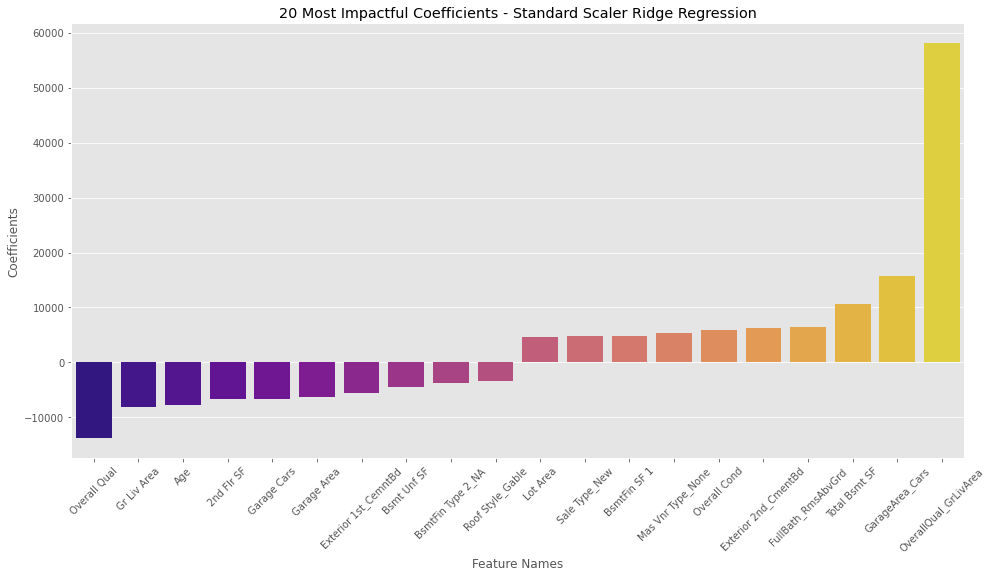

In [31]:
plt.style.use('ggplot')
plt.subplots(figsize=(16, 8))
sns.barplot('Feature Names', 'Coefficients', data=ss_graph_coefs.sort_values('Coefficients'), palette='plasma')
plt.xticks(rotation=45)
plt.title('20 Most Impactful Coefficients - Standard Scaler Ridge Regression');

### Interpreting Coefficients

What stands out to me most here is the symmetry between positive polynomial coefficients, and corresponding negative coefficients.  

The largest coefficient (\\$58,087) in this model is for Overall Quality multiplied by Above Ground Living Area. When assessing these individually, Overall Quality has a negative coefficient of -\\$13,810 and Above Ground Living Area has a negative coefficient of -\\$8038. I believe this is acting as an offset - as the value of these two features increases, the overall value of the home will increase as well - but the negative coefficients help balance out the multiplier.

We se a similar affect here with Garage Area X Cars, and a few of the Square Footage measurements.

### Ridge Regression with QuantileTransformer

In [32]:
from sklearn import set_config
set_config(display='diagram')

np.seterr(divide='ignore', invalid='ignore')

param_grid = {
    'selectkbest__k': range(100,200,5),
    'ridge__alpha' : [.01, .1, 1, 10, 100],
}

pipe2 = make_pipeline(QuantileTransformer(),SelectKBest(),Ridge())

gs2 = GridSearchCV(pipe2, param_grid, n_jobs=-1)
gs2.fit(X_dummies, y)

print('Train Score', gs2.score(X_dummies, y))
gs2.best_params_

Train Score 0.8971093670343326


{'ridge__alpha': 10, 'selectkbest__k': 190}

In [33]:
set_config(display='diagram')
gs2

GridSearchCV(estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('selectkbest', SelectKBest()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.01, 0.1, 1, 10, 100],
                         'selectkbest__k': range(100, 200, 5)})

In [35]:
y_preds_qt = gs2.predict(X_dummies)

In [36]:
qt_rmse = mean_squared_error(y, y_preds_qt, squared=False)
qt_rmse

25098.23082923839

In [37]:
residuals = y - y_preds_qt

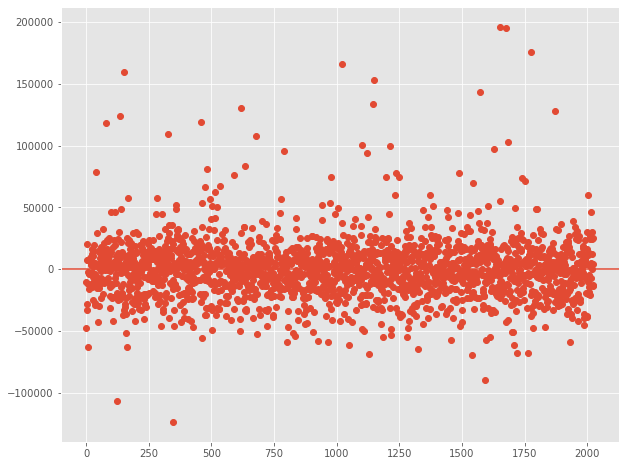

In [38]:
plt.subplots(figsize=(10,8))
plt.plot(residuals, 'o')
plt.axhline();

### Model Performance

When using Quantile Transformer instead of Standard Scaler, the score drops slightly. This model explains 89.7% of the variation in sales price. Let's dig into these coefficents.

The Root Mean Squared Error on the training data is 25,098. This is higher than the Standard Scaler model.

This residual plot shows outliers just like the Standard Scaler model, but here they are more evenly distributed. While most residuals tend to be between 5000 and -5000 here as well, the positive outliers stretch as high as 20,000.

In [39]:
selected_feature = gs2.best_estimator_.named_steps['selectkbest'].get_support()
qt_coefs = gs2.best_estimator_.named_steps['ridge'].coef_
X_cols = X_dummies.columns.values[selected_feature==True]
qt_coefs_df = pd.DataFrame({'Feature Names': X_cols,'Coefficients': qt_coefs})
qt_coefs_df

,Feature Names,Coefficients
0,1st Flr SF,24298.732897
1,2nd Flr SF,19993.614281
2,3Ssn Porch,-1599.925925
3,Age,-10237.167783
4,Age_RemodAge,-6626.916536
...,...,...
185,Total Bsmt SF,21600.032140
186,Utilities_NoSewr,-486.638096
187,Wood Deck SF,2729.860856
188,garage_age,-5598.764057


In [40]:
qt_coefs_df.sort_values(by='Coefficients', ascending=False)

,Feature Names,Coefficients
161,Neighborhood_StoneBr,34239.430006
156,Neighborhood_NridgHt,32868.292250
155,Neighborhood_NoRidge,27108.051591
166,Overall Qual,25277.326560
23,BsmtFin SF 1,24728.729515
...,...,...
114,Kitchen AbvGr,-11250.463188
9,Bldg Type_Duplex,-12419.959974
154,Neighborhood_NWAmes,-13203.282956
11,Bldg Type_TwnhsE,-17051.595268


In [41]:
qt_pos_coefs = qt_coefs_df.nlargest(10, 'Coefficients')

In [42]:
qt_neg_coefs = qt_coefs_df.nsmallest(10, 'Coefficients').sort_values(by='Coefficients', ascending=False)

In [43]:
qt_graph_coefs = pd.concat([qt_pos_coefs, qt_neg_coefs])
qt_graph_coefs

,Feature Names,Coefficients
161,Neighborhood_StoneBr,34239.430006
156,Neighborhood_NridgHt,32868.292250
155,Neighborhood_NoRidge,27108.051591
166,Overall Qual,25277.326560
23,BsmtFin SF 1,24728.729515
0,1st Flr SF,24298.732897
121,Lot Area,23771.448647
135,Mas Vnr Area,22591.295357
103,Gr Liv Area,22533.262391
52,Exterior 1st_BrkFace,21922.134911


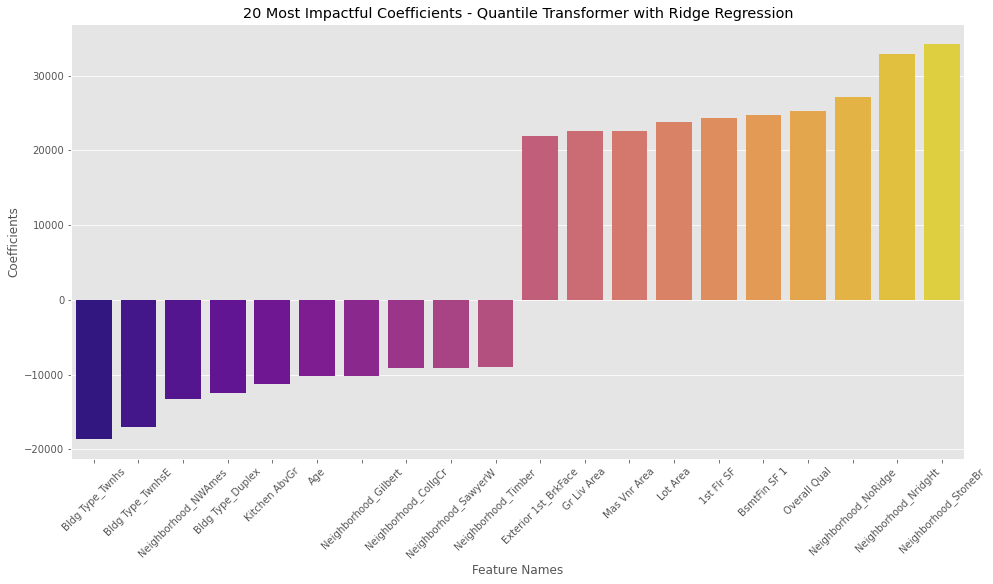

In [44]:
plt.style.use('ggplot')
plt.subplots(figsize=(16, 8))
sns.barplot('Feature Names', 'Coefficients', data=qt_graph_coefs.sort_values('Coefficients'), palette='plasma')
plt.xticks(rotation=45)
plt.title('20 Most Impactful Coefficients - Quantile Transformer with Ridge Regression');

### Interpreting Coefficients

First, a disclaimer that all above numbers related to a specific coefficient are under the assumption that all else is held constant.

**Neighborhoods:** 3 neighborhoods of Northridge, Stone Brook, and Northridge Heights have the highest coefficents, while Northwest Ames, Gilbert, College Creek and Sawyer West all have negative coefficients . These should sound familiar from our neighborhood discussion. A home in Stone Brook, for example,  is predicted to be worth \\$34,000 more. On the negative side, a house in Northwest Ames is worth \\$13,000 less.  

**Overall Quality** has the 4th largest coefficient. A nominal increase of 1 unit, such as Poor to Fair or Above Average to Good, will increase the value of a home by \\$25,000.

**Square footage:** Many of the features related to square footage and the size of the home are also in the top 10 positive coefficients. This aligns with expectations based on our exploratory data analysis.

**House age** has a negative coefficient of about \\$10,000. This aligns with our expectation that newer houses are more valuable, and the price of a given home will decrease over time.

**Building type:** is also a large factor. Here we can see that the affect of Duplex’s and Townhouses his a decreased sales price. 


### Black Box - Kaggle Model

The model below ultimately led to my best Kaggle competition score.

Here, I will also use a log transform on the target, y, and One Hot Encoder instead of get dummies.
This model also utilizes a preprocessor and column transformers.

The combination of transformers, preprocessors, piplines and grids leads to a strong model that makes strong predictions. The downside here is that the model loses interpretability once all of these model features are used together.

In [45]:
y_log = np.log(clean_train_df['SalePrice'])

In [58]:
np.seterr(divide='ignore', invalid='ignore')

num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_include='object')

preprocessor = make_column_transformer(
    (make_pipeline(StandardScaler()), num_cols),
    (make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse=False)), cat_cols)
)


param_grid = {
    'selectkbest__k': range(180,220,5),
    'ridge__alpha' : [5, 10, 15, 20],
}

pipe = make_pipeline(preprocessor,SelectKBest(),Ridge())

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=100)
grid.fit(X, y_log)

print('Train Best', grid.best_score_)
print('Train Score', grid.score(X, y_log))
grid.best_params_

Train Best 0.9118294422236147
Train Score 0.9309944203552301


{'ridge__alpha': 15, 'selectkbest__k': 210}

In [47]:
set_config(display='diagram')
grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f929a5a7e20>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f929a5a7700>)])),
                                       ('selectkbest', SelectKBest()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [5, 10, 15, 20],
                         'selectkbest__k': range(180, 220, 5)})

In [59]:
y_test_preds = grid.predict(X_real_test)

In [60]:
y_test_preds = np.e**y_test_preds

In [61]:
y_test_preds.mean()

179992.50884869866

In [62]:
clean_test_df['SalePrice'] = y_test_preds

In [63]:
final_kaggle_attempt = clean_test_df[['Id', 'SalePrice']]

In [64]:
final_kaggle_attempt.to_csv('./uploads/final_kaggle_attempt.csv', index=False)

In [57]:
# Kaggle RMSE: 18756.95

## Conclusion

**Model selection:** The three models demonstrated are all useful for different purposes. The Black Box model makes the most accurate prediction. This would be most useful for scenarios that have all of the feature information and ultimately care about getting closest to the target. Zillow and Redfin price estimators come to mind. This might also be useful for a potential buyer, who could use this model for inference: is the home they are looking to buy priced correctly? Should they negotiate a lower offer, or put in a higher bid?  
The Ridge Regression using a Quantile transformer might be most useful to a real estate firm, where neighborhood and location are of utmost important. The normalization of this model places a higher emphasis on traditional real estate metrics - location, square footage, and age.  
The Ridge Regression using Standard Scaler might be best for the homeowner and focuses on the features that can increase or decrease value of a home, and may help them make better investments. For example, the focus on overall quality and square footage may lead them to re-paint their house, upgrade appliances, or pursue a remodel or addition with greater peace of mind.

**What features matter?** The Ridge Regression models confirms what was discovered during exploratory data analysis. The three most important factors to determine Sale Price are Location (neighborhood), Size (above ground square footage, lot area, and other square footage features), and Quality (overall quality, new house dummy, overall condition, and age). 

**Areas for Further Study:** Time constraints prevented me from further investigating certain features such as home type, kitchen quality, and unique individual features such as fireplaces, pools, etc. I would also like to experiment with segmenting the model by other factors such as new vs old home, sale type, and neighborhood.